# Documentation for Standard Keras Neural Network
- ROC AUC for different masses
- learning curve
- validation curves

# Standard imports

In [84]:
! rm -rf HplusML
! wget https://jglatzer.web.cern.ch/jglatzer/hpml/pandas_INC_ge6jge4b.h5

--2019-03-19 17:19:28--  https://jglatzer.web.cern.ch/jglatzer/hpml/pandas_INC_ge6jge4b.h5
Resolving jglatzer.web.cern.ch (jglatzer.web.cern.ch)... 188.184.64.89, 2001:1458:201:a4::100:53
Connecting to jglatzer.web.cern.ch (jglatzer.web.cern.ch)|188.184.64.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51165780 (49M) [text/plain]
Saving to: ‘pandas_INC_ge6jge4b.h5.1’

pandas_INC_ge6jge4b 100%[===================>]  48.79M  53.5MB/s    in 0.9s    

2019-03-19 17:19:29 (53.5 MB/s) - ‘pandas_INC_ge6jge4b.h5.1’ saved [51165780/51165780]



In [85]:
! git clone https://github.com/JulianGlatzer/HplusML
import sys
sys.path.append("HplusML")
!cd HplusML; git pull origin

Cloning into 'HplusML'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 147 (delta 73), reused 110 (delta 39), pack-reused 0
Receiving objects: 100% (147/147), 2.88 MiB | 6.23 MiB/s, done.
Resolving deltas: 100% (73/73), done.
Already up to date.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import HpMLUtils
import HpMLPlots
import HpHyperParameterOptimisation
import HpTrainingFrame

In [87]:
df_mc=pd.read_hdf('pandas_INC_ge6jge4b.h5', 'INC_ge6jge4b')
df_mc=df_mc[df_mc.process.apply(lambda x: True if x in ["ttlight","ttb","ttc","Hp800"] else False)]
df_mc['process'].unique()

array(['ttlight', 'ttc', 'ttb', 'Hp800'], dtype=object)

# Prepare data for H+ classification

split into test and training data

In [0]:
htf=HpTrainingFrame.HpTrainingFrame(df_mc) 

In [89]:
from HpMLUtils import WeightedStandardScaler, summarizeFitData,MultiSBWeightsScaler
X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass=800)
summarizeFitData(X_train, y_train, w=w_train)

sb=MultiSBWeightsScaler(backgroundclass=0)
sb.fit(X_train,y_train, sample_weight=w_train)
X_train=sb.transform(X_train,y_train, sample_weight=w_train)
X_test=sb.transform(X_test,y_test, sample_weight=w_test)
#w_train.groupby(y_train).sum()
summarizeFitData(X_train, y_train, w=w_train)

wss=WeightedStandardScaler()
wss.fit(X_train,sample_weight=w_train)
X_train=wss.transform(X_train)
X_test=wss.transform(X_test)
#X_eval=wss.transform(X_eval)
print("Summarizing train data after weighted standard scaler")
summarizeFitData(X_train, y_train, w=w_train)
print("Summarizing test data after weighted standard scaler")
summarizeFitData(X_test, y_test, w=w_test)

X.shape= (23068, 14) y.shape= (23068,)w.shape= (23068,)
columns= Index(['nJets', 'nBTags_70', 'pT_jet1', 'Mbb_MindR_70', 'pT_jet5', 'H1_all',
       'dRbb_avg_70', 'dRlepbb_MindR_70', 'Muu_MindR_70', 'HT_jets',
       'Mbb_MaxPt_70', 'Mbb_MaxM_70', 'Mjjj_MaxPt', 'Centrality_all'],
      dtype='object')
categories= [0, 1]

sum of weights per category
       all 1464.0889689061603
         0 1457.1067579711676
         1 6.982210934992669


average
  variable/class       all         0         1
           nJets      6.99      6.99      7.43
       nBTags_70      4.06      4.06       4.1
         pT_jet1  1.77e+05  1.77e+05  2.96e+05
    Mbb_MindR_70  7.76e+04  7.73e+04  1.33e+05
         pT_jet5  5.06e+04  5.05e+04  6.68e+04
          H1_all     0.226     0.227     0.182
     dRbb_avg_70      2.28      2.28      2.42
dRlepbb_MindR_70      2.31      2.31      2.17
    Muu_MindR_70  1.05e+05  1.05e+05  1.06e+05
         HT_jets  5.69e+05  5.68e+05  8.62e+05
    Mbb_MaxPt_70  1.66e+05  1.66

define a function to build our sequential Keras model (L2 regularisation and dropout are optional)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers

def get_model(layers=[20,10,5], l2treshold=None, dropout=None):
  model = Sequential()
  for i,layer in enumerate(layers):
    if i==0:
      if l2treshold==None:
        model.add(Dense(layer, input_dim=14, activation='relu'))    
      else:
        model.add(Dense(layer, input_dim=14, activation='relu', kernel_regularizer=regularizers.l2(l2treshold)))    
    else:
      if l2treshold==None:
        model.add(Dense(layer, activation='relu'))
      else:
        model.add(Dense(layer, activation='relu', kernel_regularizer=regularizers.l2(l2treshold)))
    if dropout!=None:
      model.add(Dropout(rate=dropout))
  model.add(Dense(1, activation='sigmoid'))
  #model.add(Dense(5, activation='relu'))

  # Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
  model.summary()
  return model

define a callback to calculate the ROC AUC during the training (ROC AUC is quite unstable with our event weights, so it's not used as a direct metric)

In [0]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.w = training_data[2]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.w_val = validation_data[2]
        self.roc=[]
        self.roc_val=[]
    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred, sample_weight=self.w)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val, sample_weight=self.w_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))))
        self.roc_val.append(roc_val)
        self.roc.append(roc)
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return


In [0]:
from sklearn.metrics import roc_curve,roc_auc_score, auc
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint


def trainModel(configurations,dropout):
  roc_values={}
  roc_train_values={}
  epochs=100

  for configuration in configurations:
    callbacks=[EarlyStopping(monitor='val_loss', 
                             patience=15),
               ModelCheckpoint(filepath='model_nn_'+str(configuration)+'.hdf5', 
                               monitor='val_loss',
                               save_best_only=True),
               roc_callback(training_data=(X_train.values, y_train.values, w_train.values),validation_data=(X_test.values, y_test.values, w_test.values))
              ]
    model=get_model(layers=configuration, l2treshold=None, dropout=dropout)
    history=model.fit(X_train.values,y_train.values, sample_weight=w_train.values, 
                      batch_size=50, epochs=epochs, callbacks=callbacks, 
                      validation_data=(X_test.values, y_test.values, w_test.values))
    model.load_weights("model_nn_"+str(configuration)+".hdf5")
    y_pred=model.predict(X_test).ravel()
    y_pred_train=model.predict(X_train).ravel()
    roc=roc_auc_score(y_test, y_pred, sample_weight=w_test)
    roc_train=roc_auc_score(y_train, y_pred_train, sample_weight=w_train)
    print(configuration, roc, roc_train)
    roc_values[str(configuration)]=roc
    roc_train_values[str(configuration)]=roc_train
  
  for key in roc_values.keys():
    print(key, roc_values[key], roc_train_values[key])
  return roc_values, roc_train_values

In [110]:
configurations=[
                [64]
               ]
trainModel(configurations, None)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_282 (Dense)            (None, 64)                960       
_________________________________________________________________
dense_283 (Dense)            (None, 1)                 65        
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________
Train on 23068 samples, validate on 23217 samples
Epoch 1/100
23068/23068 [==============================] - 16s 699us/step - loss: 2.5527e-05 - binary_accuracy: 0.7751 - val_loss: 2.3294e-05 - val_binary_accuracy: 0.7932
roc-auc: 0.8728 - roc-auc_val: 0.874
Epoch 2/100
23068/23068 [==============================] - 4s 170us/step - loss: 2.2609e-05 - binary_accuracy: 0.7925 - val_loss: 2.2641e-05 - val_binary_accuracy: 0.7952
roc-auc: 0.8805 - roc-auc_val: 0.8807
Epoch 3/100
23068/23068 [==============================] - 4s 172us/

({'[64]': 0.8875706258534293}, {'[64]': 0.892495905264008})

Let's plot the history of our metrics



In [0]:
import matplotlib.pyplot as plt
#print history.history.keys()
def plotMetric(history, callbacks):
  loss_values=history.history['loss']
  val_loss_values=history.history['val_loss']
  acc_values=history.history['binary_accuracy']
  val_acc_values=history.history['val_binary_accuracy']
  rocauc_values=callbacks[2].roc
  val_rocauc_values=callbacks[2].roc_val

  bestepoch=callbacks[0].stopped_epoch-callbacks[0].patience
  
  epochs=range(1,len(acc_values)+1)
  plt.figure()
  plt.plot(epochs, loss_values, "bo",label="Training loss")
  plt.plot(epochs, val_loss_values, "b",label="Validation loss")
  plt.legend(loc=0)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.axvline(x=bestepoch)
  ax=plt.figure()
  plt.plot(epochs, acc_values, "bo",label="Training acc")
  plt.plot(epochs, val_acc_values, "b",label="Validation acc")
  plt.legend(loc=0)
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.axvline(x=bestepoch)
  ax=plt.figure()
  plt.plot(epochs, rocauc_values, "bo",label="Training ROC AUC")
  plt.plot(epochs, val_rocauc_values, "b",label="Validation ROC AUC")
  plt.legend(loc=0)
  plt.xlabel("Epochs")
  plt.ylabel("ROC AUC")
  plt.axvline(x=bestepoch)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_293 (Dense)            (None, 64)                960       
_________________________________________________________________
dense_294 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_295 (Dense)            (None, 1)                 65        
Total params: 5,185
Trainable params: 5,185
Non-trainable params: 0
_________________________________________________________________
Train on 23068 samples, validate on 23217 samples
Epoch 1/100
23068/23068 [==============================] - 17s 721us/step - loss: 2.4751e-05 - binary_accuracy: 0.7804 - val_loss: 2.2817e-05 - val_binary_accuracy: 0.7864
roc-auc: 0.8797 - roc-auc_val: 0.8782
Epoch 2/100
23068/23068 [==============================] - 4s 186us/step - loss: 2.1985e-05 - binary_accuracy: 0.7943 - val_loss: 2.2263e-05 - v

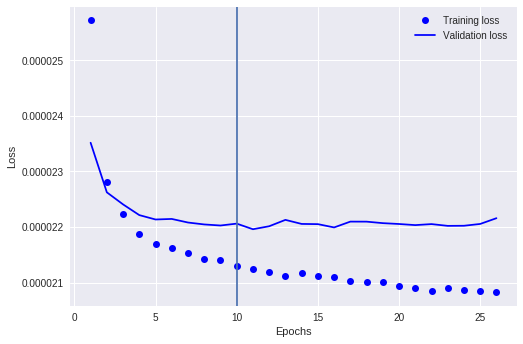

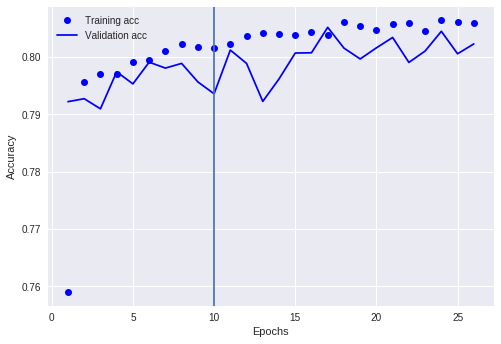

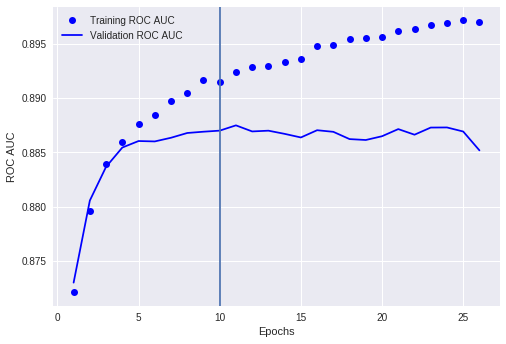

In [123]:
trainModel([[64,64]], dropout=None)
plotMetric(history, callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_296 (Dense)            (None, 64)                960       
_________________________________________________________________
dropout_129 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_297 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_130 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_298 (Dense)            (None, 1)                 65        
Total params: 5,185
Trainable params: 5,185
Non-trainable params: 0
_________________________________________________________________
Train on 23068 samples, validate on 23217 samples
Epoch 1/100
23068/23068 [==============================] - 17s 741us/step - loss: 2.5326e-

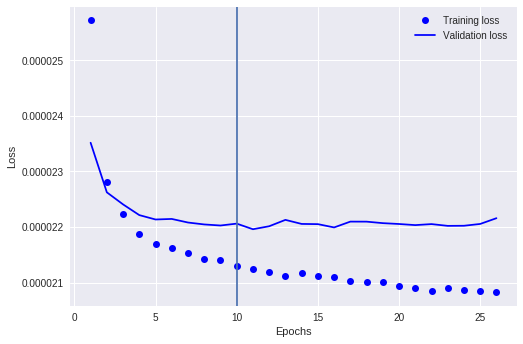

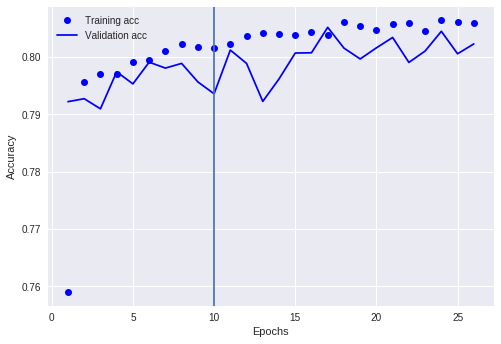

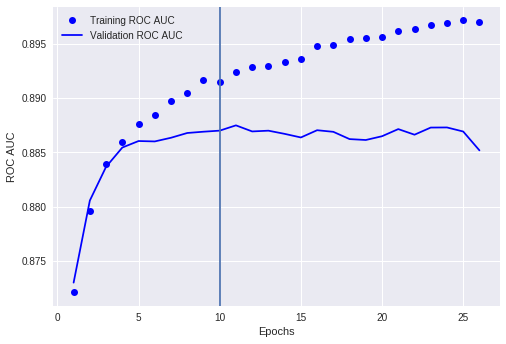

In [124]:
trainModel([[64,64]], dropout=0.1)
plotMetric(history, callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_284 (Dense)            (None, 64)                960       
_________________________________________________________________
dropout_125 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_285 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_126 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_286 (Dense)            (None, 1)                 65        
Total params: 5,185
Trainable params: 5,185
Non-trainable params: 0
_________________________________________________________________
Train on 23068 samples, validate on 23217 samples
Epoch 1/100
23068/23068 [==============================] - 17s 728us/step - loss: 2.5297e-

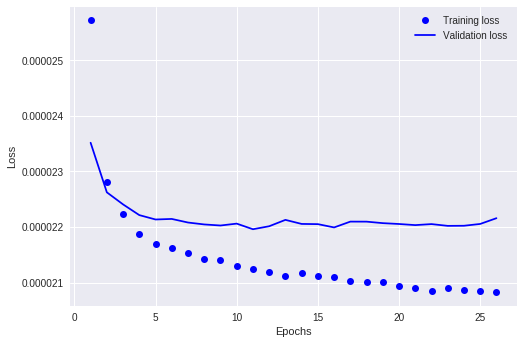

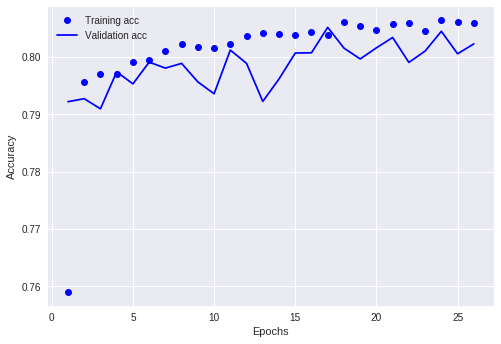

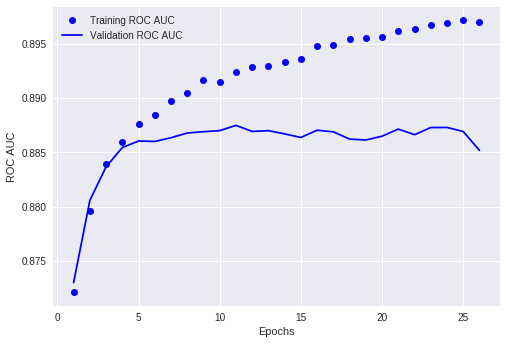

In [113]:
trainModel([[64,64]], dropout=0.2)
plotMetric(history, callbacks)

Now let's see how many layers and how many nodes per layer we need.

In [0]:
from sklearn.metrics import roc_curve,roc_auc_score, auc
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

nlayers=2
#nodes=[4,8,16,32,64]
nodes=[4,8,16]


def addLayer(inputconfs):
  confs=[]
  if len(inputconfs)==0:
    return [[size] for size in nodes]
  else:
    for conf in inputconfs:
      for size in nodes:
        if size <= conf[-1]:
          confs.append(conf+[size])
  return confs

configurations=[]

for layer in range(nlayers):
  configurations=addLayer(configurations)
  print(len(configurations), configurations)

#return

roc_values={}
roc_train_values={}
epochs=100


for configuration in configurations:
  callbacks=[EarlyStopping(monitor='val_binary_accuracy', 
                           patience=15),
             ModelCheckpoint(filepath='model_nn_'+str(configuration)+'.hdf5', 
                             monitor='val_loss',
                             save_best_only=True),
             roc_callback(training_data=(X_train.values, y_train.values, w_train.values),validation_data=(X_test.values, y_test.values, w_test.values))
            ]
  model=get_model(layers=configuration, l2treshold=None, dropout=0.1)
  history=model.fit(X_train.values,y_train.values, sample_weight=w_train.values, 
                    batch_size=50, epochs=epochs, callbacks=callbacks, 
                    validation_data=(X_test.values, y_test.values, w_test.values))
  model.load_weights("model_nn_"+str(configuration)+".hdf5")
  y_pred=model.predict(X_test).ravel()
  y_pred_train=model.predict(X_train).ravel()
  roc=roc_auc_score(y_test, y_pred, sample_weight=w_test)
  roc_train=roc_auc_score(y_train, y_pred_train, sample_weight=w_train)
  print(configuration, roc, roc_train)
  roc_values[str(configuration)]=roc
  roc_train_values[str(configuration)]=roc_train
  
for key in roc_values.keys():
  print(key, roc_values[key], roc_train_values[key])

Results of the optimization:

Either one goes for a very simple network (e.g. 1layer, 32 nodes) or a more complex, e.g. 2 layers with 64,64 nodes and dropout 0.2

```
1 layer
[4] 0.878 0.877
[8] 0.887 0.890
[16] 0.887 0.890
[32] 0.888 0.895
[64] 0.887 0.894

2 layers (no dropout, no regularisation)
[4, 4]   0.877 0.877
[8, 4]   0.883 0.890
[8, 8]   0.885 0.890
[16, 4]  0.884 0.892
[16, 8]  0.887 0.893
[16, 16] 0.886 0.894
[32, 4]  0.886 0.893
[32, 8]  0.885 0.892
[32, 16] 0.886 0.894
[32, 32] 0.885 0.897
[64, 4]  0.887 0.896
[64, 8]  0.887 0.898
[64, 16] 0.887 0.897
[64, 32] 0.887 0.894
[64, 64] 0.887 0.895

2 layers (dropout 0.1)
[4, 4]   0.883 0.884
[8, 4]   0.885 0.889
[8, 8]   0.885 0.889
[16, 4]  0.886 0.892
[16, 8]  0.887 0.890
[16, 16] 0.887 0.895
[32, 4]  0.887 0.898
[32, 8]  0.886 0.896
[32, 16] 0.887 0.896
[32, 32] 0.887 0.896
[64, 4]  0.887 0.897
[64, 8]  0.887 0.897
[64, 16] 0.887 0.900
[64, 32] 0.888 0.899
[64, 64] 0.888 0.896

2 layers (dropout 0.2)
[4, 4]   0.875 0.876
[8, 4]   0.880 0.884
[8, 8]   0.881 0.885
[16, 4]  0.886 0.894
[16, 8]  0.885 0.888
[16, 16] 0.887 0.892
[32, 4]  0.887 0.897
[32, 8]  0.888 0.894
[32, 16] 0.887 0.893
[32, 32] 0.888 0.896
[64, 4]  0.887 0.896
[64, 8]  0.887 0.896
[64, 16] 0.888 0.895
[64, 32] 0.888 0.898
[64, 64] 0.889 0.893

2 layers (dropout 0.5)
[4, 4]   0.853 0.851
[8, 4]   0.871 0.872
[8, 8]   0.871 0.871
[16, 4]  0.878 0.879
[16, 8]  0.881 0.884
[16, 16] 0.884 0.886
[32, 4]  0.886 0.887
[32, 8]  0.887 0.891
[32, 16] 0.887 0.891
[32, 32] 0.886 0.890
[64, 4]  0.887 0.894
[64, 8]  0.888 0.895
[64, 16] 0.888 0.896
[64, 32] 0.887 0.896
[64, 64] 0.888 0.895
```



In [94]:
history.history.keys()
callbacks[2].roc_val

[0.8735486709695017,
 0.880574545726035,
 0.8840882541732706,
 0.8857195153713127,
 0.8851311336647998,
 0.8869033446569659,
 0.8873959978293494,
 0.8875285063240731,
 0.8875557153638287,
 0.8869071041298775,
 0.8877140912490786,
 0.8869302907168287,
 0.8865248236848849,
 0.887222635447392,
 0.8873754820164217,
 0.8869670057498316,
 0.8872485080042127,
 0.8864973218113206,
 0.887334432575637,
 0.8872564196765405,
 0.8874210503734423,
 0.8869726903488397,
 0.8874874192234918,
 0.8869106449342742,
 0.8873810847324213,
 0.8866209732331354,
 0.8850203100931542,
 0.8867765597972745,
 0.8873876088124355,
 0.8861595953088299,
 0.8863410726427221,
 0.8864583535749233,
 0.8866117193424656,
 0.8859395094542664,
 0.886367909038347,
 0.8865542390616414,
 0.8848838193221826,
 0.8847051025147652,
 0.885547251574478,
 0.8864204682495498,
 0.8863688891604372,
 0.8854599896249805]

In [83]:
print(X_train.values[0,:].shape)
model.predict(X_train.values[0:1,:])
for layer in model.layers:
  print(layer.name,"out=", layer.output,layer.output[0],layer.output[0][0])#[0])
  print("inputs:",layer.input)
  print("activations:",layer.activations)
  print("outputs:",layer.output)
  #print("weights:",layer.get_weights())

(14,)
dense_275 out= Tensor("dense_275/Relu:0", shape=(?, 64), dtype=float32) Tensor("strided_slice_109:0", shape=(64,), dtype=float32) Tensor("strided_slice_111:0", shape=(), dtype=float32)
inputs: Tensor("dense_275_input:0", shape=(?, 14), dtype=float32)


AttributeError: ignored

['loss', 'val_binary_accuracy', 'val_loss', 'binary_accuracy']


Text(0,0.5,'Accuracy')

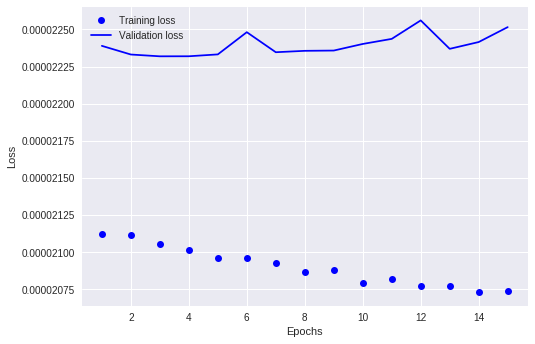

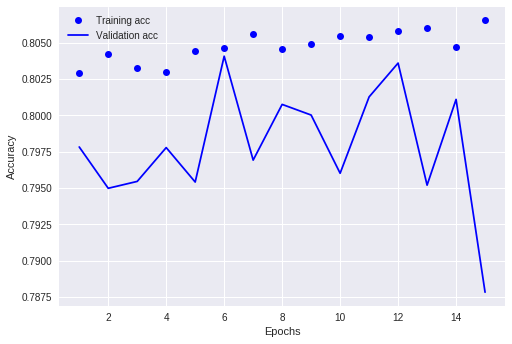

['loss', 'val_binary_accuracy', 'val_loss', 'binary_accuracy']


Text(0,0.5,'Accuracy')

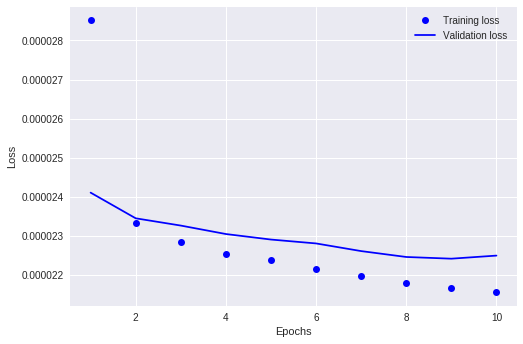

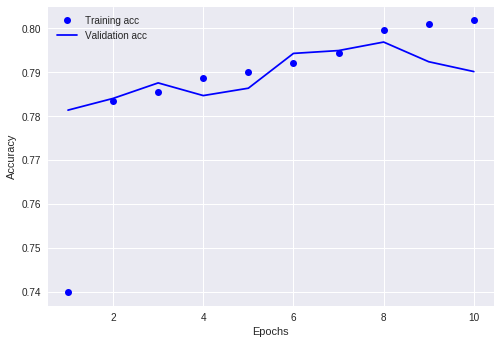

In [0]:
import matplotlib.pyplot as plt
print history.history.keys()
loss_values=history.history['loss']
val_loss_values=history.history['val_loss']
acc_values=history.history['binary_accuracy']
val_acc_values=history.history['val_binary_accuracy']

epochs=range(1,len(acc_values)+1)
plt.figure()
plt.plot(epochs, loss_values, "bo",label="Training loss")
plt.plot(epochs, val_loss_values, "b",label="Validation loss")
plt.legend(loc=0)
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax=plt.figure()
plt.plot(epochs, acc_values, "bo",label="Training acc")
plt.plot(epochs, val_acc_values, "b",label="Validation acc")
plt.legend(loc=0)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
#print history.history.keys()
#print lossvalues

In [0]:
y_pred=model.predict(X_test).ravel()

array([0.8706987 , 0.784187  , 0.8711462 , ..., 0.96393836, 0.22757512,
       0.29982105], dtype=float32)

In [0]:
from sklearn.metrics import roc_curve,roc_auc_score, auc
y_pred=model.predict(X_test).ravel()
print roc_auc_score(y_test, y_pred, sample_weight=w_test)

0.8853078263981311


# Compare the results to the standard BDT

In [100]:
import HpAlgorithms
clf=HpAlgorithms.getGradientBDTClassifier()
Xbdt_train, Xbdt_test, Xbdt_eval, ybdt_train, ybdt_test,ybdt_eval, wbdt_train, wbdt_test, wbdt_eval=htf.prepare(hpmass=800)
#summarizeFitData(Xbdt_train, ybdt_train, w=wbdt_train)
sb=MultiSBWeightsScaler(backgroundclass=0)
sb.fit(Xbdt_train,ybdt_train, sample_weight=wbdt_train)
Xbdt_train=sb.transform(Xbdt_train,ybdt_train, sample_weight=wbdt_train)
Xbdt_test=sb.transform(Xbdt_test,ybdt_test, sample_weight=wbdt_test)
#summarizeFitData(Xbdt_train, ybdt_train, w=wbdt_train)
clf.fit(Xbdt_train,ybdt_train, sample_weight=wbdt_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.13, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.01, n_estimators=120,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [98]:
from sklearn.metrics import roc_curve,roc_auc_score, auc
print(roc_auc_score(ybdt_test, clf.decision_function(Xbdt_test), sample_weight=wbdt_test))

0.8837703139912665


NN results by itself are quite a bit better than the best BDT

